
https://www.ngdc.noaa.gov/stp/satellite/goes/index.html

https://omniweb.gsfc.nasa.gov/form/dx1.html

FTP:

https://spdf.gsfc.nasa.gov/pub/data/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
# from spacepy import pycdf
import netCDF4 as nc
import pytz
import cartopy.crs as ccrs
import datetime
from utilities.IONEX import dmd_ionex
import glob
# from datetime import datetime
import datetime
import pandas as pd
import re
import scipy.io

from utilities.IONEX import IONEX,ionex_filename_to_date
from utilities.IONEX import dmd_ionex


import seaborn as sns
from scipy import interpolate


# % matplotlib qt
# Larger figure size
fig_size = [19, 15]
plt.rcParams['figure.figsize'] = fig_size

In [2]:
EUV_FOLDER = 'EUVs'
YEARS = [2013,2014]

CUR_DIR = os.path.abspath(os.getcwd())

files = glob.glob(os.path.join(CUR_DIR,EUV_FOLDER,'*.nc'))
files.sort()

files_csv = glob.glob(os.path.join(CUR_DIR,EUV_FOLDER,'*.csv'))
files_csv.sort()


euv_files_dict = {year:f_name for f_name in files for year in YEARS if str(year) in f_name}

# ncDs = nc.Dataset(euv_files_dict[2014])
# print(ncDs.variables.keys())
# files_csv
files,files_csv,euv_files_dict

(['/Volumes/SSD PhD/PhD/TEC/EUVs/dn_geuv-l2-cpy1m_g15_y2013_v4-0-0.nc',
  '/Volumes/SSD PhD/PhD/TEC/EUVs/dn_geuv-l2-cpy1m_g15_y2014_v4-0-0.nc'],
 ['/Volumes/SSD PhD/PhD/TEC/EUVs/xrs_2013_2014.csv'],
 {2013: '/Volumes/SSD PhD/PhD/TEC/EUVs/dn_geuv-l2-cpy1m_g15_y2013_v4-0-0.nc',
  2014: '/Volumes/SSD PhD/PhD/TEC/EUVs/dn_geuv-l2-cpy1m_g15_y2014_v4-0-0.nc'})

In [3]:
euvs_df = pd.DataFrame(columns=['time','irr_1216_1nm'])
euvs_df.head()

for year in euv_files_dict.keys():
    ncDs = nc.Dataset(euv_files_dict[year])
    time = np.array(list(map(datetime.datetime.utcfromtimestamp,np.array(ncDs['time']))))
    euv_irr = np.array(ncDs['irr_1216_1nm'])
    
    # euv_irr[euv_irr < 0] = 0
    euv_irr[euv_irr < 0] = np.nan
    euv_irr = pd.Series(euv_irr,name='irr_1216_1nm')
    euv_irr = euv_irr.interpolate(inplace=False,method='polynomial',order=1)
    time = pd.Series(time,name='time')

    
    euvs_df = euvs_df.append(pd.concat([euv_irr, time], axis=1),ignore_index=True)
        
# REMOVE EVERY SECOND ROW
# euvs_df = euvs_df.iloc[::2, :]

# euvs_df = pd.read_csv(files_csv[0])

# euvs_df = euvs_df.rename(columns={"datetime":"time","cnt_inter":"irr_1216_1nm"})
# euvs_df = euvs_df.loc[:, ~euvs_df.columns.str.contains('^Unnamed')]

# euvs_df['time'] = pd.to_datetime(euvs_df['time'],format='%Y-%m-%d %H:%M:%S')
# euvs_df['time'] = euvs_df['time'].dt.round(freq='S')
# euvs_df['time'] = euvs_df['time'] + pd.to_timedelta(euvs_df['time'].dt.second % 2,unit='s')

# euvs_df = euvs_df.dropna()
euvs_df

,time,irr_1216_1nm
0,2013-01-01 00:00:26.999918,0.007599
1,2013-01-01 00:01:26.999918,0.007610
2,2013-01-01 00:02:26.999918,0.007615
3,2013-01-01 00:03:26.999918,0.007610
4,2013-01-01 00:04:26.999918,0.007604
...,...,...
1051195,2014-12-31 23:55:26.999918,0.008150
1051196,2014-12-31 23:56:26.999918,0.008148
1051197,2014-12-31 23:57:26.999918,0.008148
1051198,2014-12-31 23:58:26.999918,0.008142


In [4]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


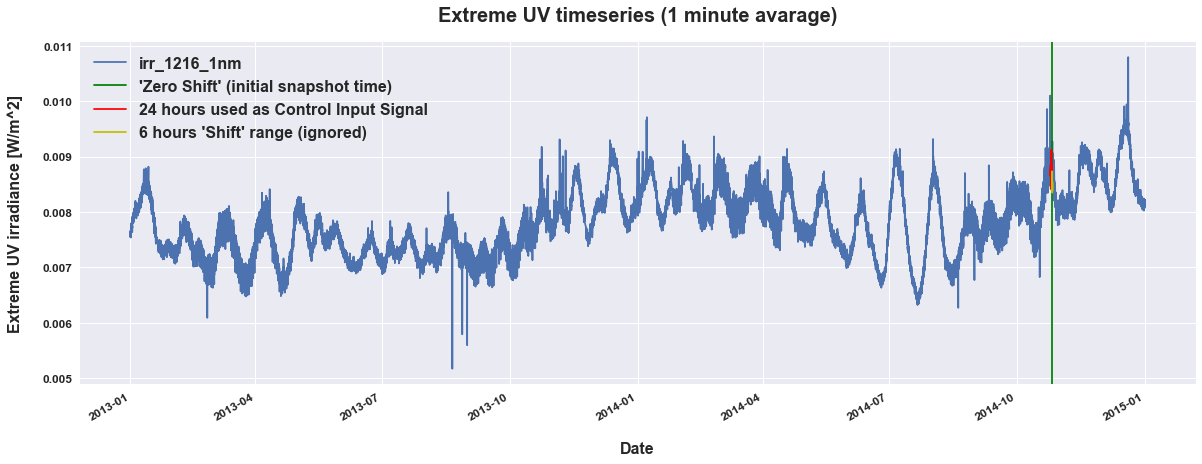

In [5]:
%matplotlib inline

plt.style.use('seaborn')

# plt.figure(figsize=(150,7))
fig, ax = plt.subplots(figsize=(20,7))

ax = euvs_df.plot(x='time',y='irr_1216_1nm',ax=ax)

zero_shift = datetime.datetime(2014,10,26,10,0,0)
shift_range = (zero_shift-datetime.timedelta(hours=6),zero_shift)
shift_mask = (euvs_df['time'] >= shift_range[0]) &  (euvs_df['time'] < shift_range[1])
# print(shift_mask)
# ax.plot(euvs_df['irr_1216_1nm'][shift_mask],c='r')

cnt_range = (shift_range[0]-datetime.timedelta(hours=24),shift_range[0])
cnt_mask = (euvs_df['time'] >= cnt_range[0]) &  (euvs_df['time'] < cnt_range[1])

ax.axvline(x=zero_shift, ymin=0, ymax=1,c='g',label = '\'Zero Shift\' (initial snapshot time)')
euvs_df[cnt_mask].plot(x='time',y='irr_1216_1nm',ax=ax,c='r',label='24 hours used as Control Input Signal')
euvs_df[shift_mask].plot(x='time',y='irr_1216_1nm',ax=ax,c='y',label='6 hours \'Shift\' range (ignored)')

ax.set_xlabel("Date",fontsize = 16,fontweight='bold',labelpad=20)
ax.set_ylabel("Extreme UV irradiance [W/m^2]",fontsize = 16,fontweight='bold',labelpad=20)
ax.set_title('Extreme UV timeseries (1 minute avarage)',fontsize = 20,fontweight='bold',pad=20)

plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')

plt.legend(prop={'weight':'bold','size':16})
plt.show()

In [6]:
ionex_igs = IONEX(save_directory=os.path.join(os.path.abspath('.'),'ionex_igs'),centre='igs')
ionex_c1p = IONEX(save_directory=os.path.join(os.path.abspath('.'),'ionex_c1p'),centre='c1p')
# ionex_igr = IONEX(save_directory=os.path.join(os.path.abspath('.'),'ionex_igr'),centre='igr')

days_list = list(range(1,366)) # all years days [1,365]
years_list = YEARS#[2013]
# gps = ionex_gps.get_numpy_tecmaps(years_list,dyas_list)

c1p,c1p_file_names = ionex_c1p.get_numpy_tecmaps(years_list,days_list)
igs,igs_file_names = ionex_igs.get_numpy_tecmaps(years_list,days_list)

igr_rms,igr_rms_file_names = ionex_igs.get_numpy_rmsmaps(years_list,days_list)


Year : 2013, Days :  79%|███████▉  | 289/365 [00:33<00:08,  9.11it/s]

[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2880.13i' /Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2880.13i
[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2900.13i' /Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2900.13i


Year : 2013, Days :  81%|████████  | 295/365 [00:34<00:05, 12.02it/s]

[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2930.13i' /Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2930.13i
[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2940.13i' /Volumes/SSD PhD/PhD/TEC/ionex_c1p/2013/c1pg2940.13i


Year : 2013, Days :  79%|███████▉  | 289/365 [00:43<00:10,  7.49it/s]

[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2880.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2880.13i
[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2900.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2900.13i


Year : 2013, Days :  81%|████████  | 295/365 [00:44<00:06, 10.42it/s]

[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2930.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2930.13i
[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2940.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igs/2013/igsg2940.13i


Year : 2013, Days :  79%|███████▉  | 289/365 [00:37<00:08,  8.49it/s]

[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2880.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2880.13i
[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2900.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2900.13i


Year : 2013, Days :  81%|████████  | 295/365 [00:37<00:05, 11.68it/s]

[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2930.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2930.13i
[Errno 2] No such file or directory: '/Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2940.13i' /Volumes/SSD PhD/PhD/TEC/ionex_igr/2013/igrg2940.13i


Year : 2014, Days : 100%|██████████| 365/365 [01:23<00:00,  4.38it/s]


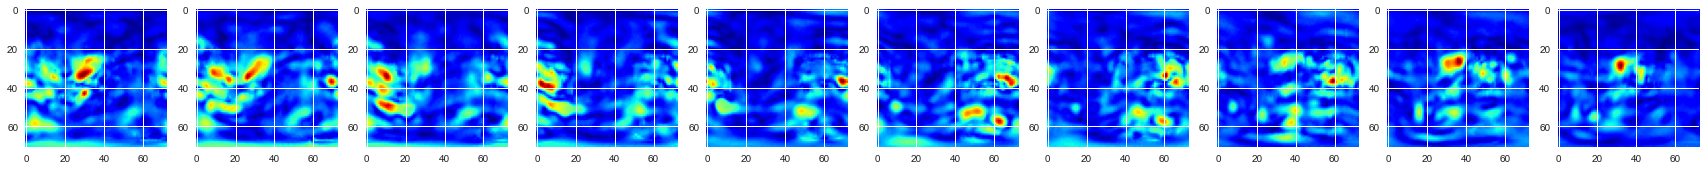

(None, (726, 13, 71, 73))

In [7]:


# plt.figure(figsize=(15,15))
fig,axs = plt.subplots(1,10,figsize=(30,30))

for i,ax in enumerate(axs):
    ax.imshow(igr_rms[100,i,:,:],cmap='jet')

plt.show(),igr_rms.shape

/Users/vladlanda/opt/anaconda3/envs/phd37/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


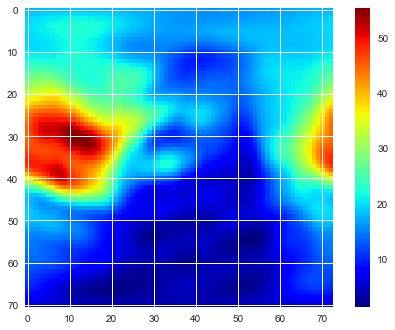

In [8]:
# n_days,n_samples,height,width = igs.shape
#[16:30,38:48]
# igs_cp = igs[:,:-1,18:28,40:46]
# c1p_cp = c1p[:,:-1,18:28,40:46]
igs_cp = igs[:,:-1,:,:] #* 10
c1p_cp = c1p[:,:-1,:,:] #* 10
igr_rms_cp = igr_rms[:,:-1,:,:]
igs_cp.shape,c1p_cp.shape

plt.imshow(igs_cp[215,0,:,:],cmap='jet')
plt.colorbar()
plt.show()

In [9]:
# a = igs_file_names[0]
# res = ionex_filename_to_date(a)
# printing result
# print(type(res),res),res == datetime.datetime(2013,1,1)

# euvs_df = df
daily_irr = []

# min_dayli_seconds = 41000
days=3
padding = 60*24*days
for filename in igs_file_names:
    file_date = ionex_filename_to_date(filename)
    #---------------------------------------------------------------------------------NORMAL-----------------------------------------------------------
    # _start_date = file_date.strftime("%Y-%m-%d")
    # _end_date = (file_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    # date_mask = (euvs_df['time'] >= _start_date) & (euvs_df['time'] < _end_date)
    # irr = euvs_df['irr_1216_1nm'].loc[date_mask].to_numpy()
    
    irr = []
    for t in range(0,24,2):
        
        _end_date = (file_date + datetime.timedelta(hours=t)).strftime("%Y-%m-%d %H:%m")
        _start_date = (file_date +datetime.timedelta(hours=t)- datetime.timedelta(days=days)).strftime("%Y-%m-%d %H:%m")
        
        # print(_end_date,_start_date)

        date_mask = (euvs_df['time'] >= _start_date) & (euvs_df['time'] < _end_date)
        irr_24h = euvs_df['irr_1216_1nm'].loc[date_mask].to_numpy()
        if padding-irr_24h.shape[0] < 0:
            irr_24h = irr_24h[1:]
        # print(padding-irr_24h.shape[0],_end_date,_start_date)
        irr_24h=np.pad(irr_24h,(padding-irr_24h.shape[0],0))
        # print(_end_date,_start_date,irr_24h.shape)

        irr.append(irr_24h)

        
    
    # print(filename,_start_date,_end_date)
    # (euvs_df['time'] >= _start_date) and (euvs_df['time'] <= _end_date) 
    # print(euvs_df['time'] > _start_date  euvs_df['time'] < _start_date)







    # print(irr.shape,_start_date)
    # if irr.shape[0] > 0:
    #     indxs = np.random.choice(irr.shape[0],size=min_dayli_seconds,replace=False)
    #     indxs = np.sort(indxs)
    #     irr = irr[indxs]
    # else:
    #     irr = np.zeros(shape=irr.shape)
    # print(_start_date,irr.shape)
    daily_irr.append(np.array(irr))
    # print(euvs_df['irr_1216_1nm'].loc[date_mask].to_numpy())
    # break

daily_irr = np.array(daily_irr)
daily_irr = daily_irr.reshape(igs_cp.shape[0],igs_cp.shape[1],-1)

# f = interpolate.interp1d(np.arange(0,daily_irr.shape[2]), daily_irr,axis=2,kind='cubic')
# daily_irr = f(np.arange(0, daily_irr.shape[2]-1, 0.0166667))
daily_irr.shape

(726, 12, 4320)

In [10]:
# daily_irr = c1p_cp.reshape(726,12,-1)

In [11]:
print(daily_irr.shape,igs_cp.shape,c1p_cp.shape)

(726, 12, 4320) (726, 12, 71, 73) (726, 12, 71, 73)


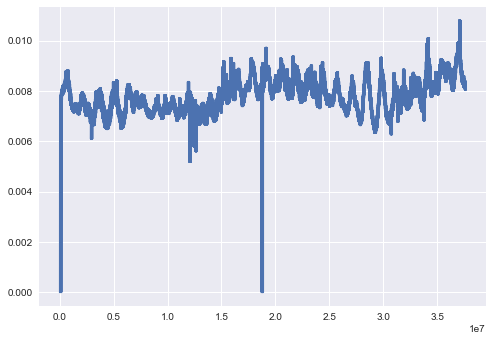

In [12]:
plt.plot(daily_irr.reshape(-1))
plt.show()

### DMDc

In [13]:
def DMD(X,Xprime,r=None,thr=1e-10):
    
    U,S,Vt = np.linalg.svd(X,full_matrices=False)
    n_rows,n_cols = X.shape
    if r is None:
        r = np.sum(S > thr)
    # r = int(np.ceil(r))
    Ur = U[:,:r]
    Sr = np.diag(S[:r])
    Vtr = Vt[:r,:]

    Atilda = Ur.T @ Xprime @ Vtr.T @ np.diag(1.0/S[:r])
    W,Lambda = np.linalg.eig(Atilda)
    W = np.diag(W)
    Phi = Xprime @ Vtr.T @ np.diag(1.0/S[:r]) @ W
    
    return (Phi,Ur,Atilda,np.nan)

def DMDc(X,Xprime,Y=None,r=None,p=None,thr=1e-10):
    if not p is None and not r is None: 
        if p <= r : raise Exception("truncation value 'p' must be greater then truncation value 'r'")
    # 1.
    OMEGA = X
    x_shape = X.shape
    if not Y is None: 

        OMEGA = np.concatenate((X,Y),axis=0)
    else:
        return DMD(X,Xprime)

    U_omega,S_omega,Vt_omega = np.linalg.svd(OMEGA,full_matrices=False)
    
    if p is None:
        p = np.sum(S_omega > thr)
    Up_omega = U_omega[:,:p]
    Sp_omega = np.diag(1.0/S_omega[:p])
    Vtp_omega = Vt_omega[:p,:]
    
    if not Y is None:
        Up_omega_1 = Up_omega[:x_shape[0],:]
        Up_omega_2 = Up_omega[x_shape[0]:,:]
    else:
        Up_omega_1 = Up_omega
        Up_omega_2 = np.zeros(shape=Sp_omega.shape)#np.array([1])#Up_omega[x_shape[0]:,:]
    # 3.
    U_prime,S_prime,Vt_prime = np.linalg.svd(Xprime,full_matrices=False)

    if r is None:
        r = np.sum(S_prime > thr)
    Ur_prime = U_prime[:,:r]
    Sr_prime = np.diag(1.0/S_prime[:r])
    Vtr_prime = Vt_prime[:r,:]

    # 4.
    A_tilda = Ur_prime.T @ Xprime @ Vtp_omega.T @ Sp_omega @ Up_omega_1.T @ Ur_prime
    B_tilda = Ur_prime.T @ Xprime @ Vtp_omega.T @ Sp_omega @ Up_omega_2.T
    #5.
    W,Lambda = np.linalg.eig(A_tilda)
    Phi = Xprime @ Vtp_omega.T @  Sp_omega @ Up_omega_1.T @ Ur_prime @ W

    return (Phi,Ur_prime,A_tilda,B_tilda)

def maps_rmse(m1,m2):
    return np.sqrt(np.mean(np.square(m1-m2),axis=(1,2)))

def latlon2index(latlon,shape):
    lat,lon = latlon
    height,width = shape
    
    row = int((87.5 - lat)/175.0 * height)
    col = int((lon + 180)/360.0 * width)
    
    return (row,col)
    
def sats_path_2_days(sat_paths_file):
    sat_paths = scipy.io.loadmat(sat_paths_file)
    keys_list = list(sat_paths.keys())[3:]
    key_pairs = list(zip(keys_list[::2],keys_list[1::2]))

    return list(np.concatenate((sat_paths[a[0]],sat_paths[a[1]])).T for a in key_pairs)

def sattelite_path_maps_rmse(m1,m2,sat_paths_file):

    def build_sparse_mat(mat,sats_latlons):
        mat_sparse = np.zeros(mat.shape)
        # print(mat_sparse.shape,mat.shape)
        for latlon in sats_latlons:
            # print(latlon)
            # if latlon[0] == 0 or latlon[1] == 0 : continue
            row,col = latlon2index(latlon,mat.shape)
            # sat_map[row][col] = 1

            mat_sparse[row][col] = mat[row][col]

        
        # plt.imshow(mat_sparse)
        
        mat_sparse = np.expand_dims(mat_sparse, axis=0)
        return mat_sparse



    # m1_sparse = np.zeros(m1.shape)
    # m2_sparse = np.zeros(m2.shape)

    sats_days_list = sats_path_2_days(sat_paths_file)
    m1_sparse = np.concatenate(tuple(build_sparse_mat(m1[i],sats) for i,sats in enumerate(sats_days_list)) )
    m2_sparse = np.concatenate(tuple(build_sparse_mat(m2[i],sats) for i,sats in enumerate(sats_days_list)) )

    # mask = b != 0 
    # mask,np.sum(mask)

    diff = m1_sparse-m2_sparse
    return np.sqrt(np.sum(np.square(diff),axis=(1,2)) / np.sum(m1_sparse != 0,axis=(1,2))) 
    
    

def DMDc_prediction(snapshots_mat,controls_mat,upto_date_index,n_train_indecies,n_pred_days,n_samples = 12):
    A = snapshots_mat
    B = controls_mat
    # print("B : ",B.shape)


    pred_maps = []

    for pred_day_number in range(n_pred_days):

        day_shift = pred_day_number * n_samples

        in_start = upto_date_index - n_train_indecies + day_shift
        in_end = upto_date_index - 1 + day_shift

        out_start = in_start + 1 
        out_end = in_end + 1

        X = A[:,in_start:in_end]
        Xprime = A[:,out_start:out_end]

        # X = X - np.mean(X)
        # X = X /  np.std(X)

        # Xprime = Xprime - np.mean(Xprime)
        # Xprime = Xprime /  np.std(Xprime)

        Y = None
        if not B is None:
            
            Y = B[:,in_start:in_end]

            a_max,a_min = np.max(A),np.min(A)
            y_max,y_min = np.max(Y),np.min(Y)

            Y = Y - np.mean(Y)
            Y = Y / np.std(Y)

            # Y = Y * (np.mean(A) / np.mean(Y))
            # Y = Y * (np.median(A) / np.median(Y))

            # Y = (Y-y_min) / (y_max-y_min)
            # Y = (Y * (a_max-a_min)) + a_min
        
        
        (Phi,Ur_prime,A_tilda,B_tilda) = DMDc(X,Xprime,Y)


        a = A[:,in_end]
        
        pred_day = []
        for sample_idx in range(n_samples+1):

            a_tilda = Ur_prime.T @ a
            p = Ur_prime @ (A_tilda @ a_tilda)
            if not B_tilda is np.nan:
                y = B[:,in_end + sample_idx]
                p = Ur_prime @ (A_tilda @ a_tilda + B_tilda @ y)

            
            pred_day.append(p)
            a = p

        pred_maps.append(pred_day)

    pred_maps = np.array(pred_maps)

    return pred_maps

def compare_DMDc_date_base(tec_source,tec_source_filenames,control_source,compare_source,datetime_list,sat_paths_file=None,n_days_to_train=120):

    dates = list(map(ionex_filename_to_date,tec_source_filenames))

    d,s,h,w = tec_source.shape

    A = tec_source.reshape(d*s,h*w).T
    B=None
    if not control_source is None :B = control_source.reshape(d*s,-1).T
    C = compare_source.reshape(d*s,h*w).T

    n_samples = s


    comparison = {}

    for date in datetime_list:
        
        day_index = dates.index(date)
        train_range = n_days_to_train if n_days_to_train <= day_index else day_index

        day_index*=n_samples
        train_range*=n_samples

        
        # pred_tec=None
        # print(B.shape)
        full_pred_tec = DMDc_prediction(A,B,day_index,train_range,1,n_samples)
        full_pred_tec_no_control = DMDc_prediction(A,None,day_index,train_range,1,n_samples)

        #------------------------------------------------------------------------------SHIFTING------------------------------------------------------------
        shift = 2
        full_pred_tec_shift_2 = DMDc_prediction(A,np.pad(B, ((0,0),(shift,0)))[:,:-shift],day_index,train_range,1,n_samples)
        shift = 4
        full_pred_tec_shift_4 = DMDc_prediction(A,np.pad(B, ((0,0),(shift,0)))[:,:-shift],day_index,train_range,1,n_samples)
        shift = 6
        full_pred_tec_shift_6 = DMDc_prediction(A,np.pad(B, ((0,0),(shift,0)))[:,:-shift],day_index,train_range,1,n_samples)
        shift = 8
        full_pred_tec_shift_8 = DMDc_prediction(A,np.pad(B, ((0,0),(shift,0)))[:,:-shift],day_index,train_range,1,n_samples)
        shift = 10
        full_pred_tec_shift_10 = DMDc_prediction(A,np.pad(B, ((0,0),(shift,0)))[:,:-shift],day_index,train_range,1,n_samples)
        shift = 12
        full_pred_tec_shift_12 = DMDc_prediction(A,np.pad(B, ((0,0),(shift,0)))[:,:-shift],day_index,train_range,1,n_samples)

        pred_tec_shift_2 =   full_pred_tec_shift_2.reshape(1,n_samples+1,h,w).squeeze(0)[:-1].reshape(n_samples,h,w)
        pred_tec_shift_4 =   full_pred_tec_shift_4.reshape(1,n_samples+1,h,w).squeeze(0)[:-1].reshape(n_samples,h,w)
        pred_tec_shift_6 =   full_pred_tec_shift_6.reshape(1,n_samples+1,h,w).squeeze(0)[:-1].reshape(n_samples,h,w)
        pred_tec_shift_8 =   full_pred_tec_shift_8.reshape(1,n_samples+1,h,w).squeeze(0)[:-1].reshape(n_samples,h,w)
        pred_tec_shift_10 = full_pred_tec_shift_10.reshape(1,n_samples+1,h,w).squeeze(0)[:-1].reshape(n_samples,h,w)
        pred_tec_shift_12 = full_pred_tec_shift_12.reshape(1,n_samples+1,h,w).squeeze(0)[:-1].reshape(n_samples,h,w)

        #------------------------------------------------------------------------------SHIFTING------------------------------------------------------------
        
        # pred_tec_no_control = DMDc_prediction(A,B[::2,:],day_index,train_range,1,n_samples)

        # full_pred_tec -= np.min(full_pred_tec.reshape(1,n_samples+1,-1))
        # full_pred_tec_no_control -= np.min(full_pred_tec_no_control.reshape(1,n_samples+1,-1))

        full_pred_tec = full_pred_tec.reshape(1,n_samples+1,h,w)
        full_pred_tec_no_control = full_pred_tec_no_control.reshape(1,n_samples+1,h,w)
        # print(full_pred_tec.shape)

        pred_tec = full_pred_tec.squeeze(0)[:-1].reshape(n_samples,h,w)
        pred_tec_no_control = full_pred_tec_no_control.squeeze(0)[:-1].reshape(n_samples,h,w)
        
        
        true_tec = A[:,day_index:day_index + n_samples].T.reshape(n_samples,h,w)
        ref_tec = C[:,day_index:day_index + n_samples].T.reshape(n_samples,h,w)


        #16:30,38:48 [:,16:30,38:48]
        



        if sat_paths_file:

            

            ref_rmse =                  sattelite_path_maps_rmse(true_tec,ref_tec               ,sat_paths_file)
            pred_rmse =                 sattelite_path_maps_rmse(true_tec,pred_tec              ,sat_paths_file)
            no_control_rmse =           sattelite_path_maps_rmse(true_tec,pred_tec_no_control   ,sat_paths_file)

            pred_tec_shift_2_rmse =     sattelite_path_maps_rmse(true_tec ,pred_tec_shift_2     ,sat_paths_file)
            pred_tec_shift_4_rmse =     sattelite_path_maps_rmse(true_tec ,pred_tec_shift_4     ,sat_paths_file)
            pred_tec_shift_6_rmse =     sattelite_path_maps_rmse(true_tec ,pred_tec_shift_6     ,sat_paths_file)
            pred_tec_shift_8_rmse =     sattelite_path_maps_rmse(true_tec ,pred_tec_shift_8     ,sat_paths_file)
            pred_tec_shift_10_rmse =    sattelite_path_maps_rmse(true_tec,pred_tec_shift_10     ,sat_paths_file)
            pred_tec_shift_12_rmse =    sattelite_path_maps_rmse(true_tec,pred_tec_shift_12     ,sat_paths_file)

            print(ref_rmse.shape,pred_tec_shift_12_rmse.shape)

        else:
            # ref_rmse = maps_rmse(true_tec[:,16:30,38:48],ref_tec[:,16:30,38:48])
            # pred_rmse = maps_rmse(true_tec[:,16:30,38:48],pred_tec[:,16:30,38:48])
            # no_control_rmse = maps_rmse(true_tec[:,16:30,38:48],pred_tec_no_control[:,16:30,38:48])
            # pred_tec_shift_2_rmse =  maps_rmse(true_tec[:,16:30,38:48], pred_tec_shift_2[:,16:30,38:48])
            # pred_tec_shift_4_rmse =  maps_rmse(true_tec[:,16:30,38:48], pred_tec_shift_4[:,16:30,38:48])
            # pred_tec_shift_6_rmse =  maps_rmse(true_tec[:,16:30,38:48], pred_tec_shift_6[:,16:30,38:48])
            # pred_tec_shift_8_rmse =  maps_rmse(true_tec[:,16:30,38:48], pred_tec_shift_8[:,16:30,38:48])
            # pred_tec_shift_10_rmse = maps_rmse(true_tec[:,16:30,38:48],pred_tec_shift_10[:,16:30,38:48])
            # pred_tec_shift_12_rmse = maps_rmse(true_tec[:,16:30,38:48],pred_tec_shift_12[:,16:30,38:48])


            ref_rmse = maps_rmse(true_tec,ref_tec)
            pred_rmse = maps_rmse(true_tec,pred_tec)
            no_control_rmse = maps_rmse(true_tec,pred_tec_no_control)

            pred_tec_shift_2_rmse = maps_rmse(true_tec ,pred_tec_shift_2 )
            pred_tec_shift_4_rmse = maps_rmse(true_tec ,pred_tec_shift_4 )
            pred_tec_shift_6_rmse = maps_rmse(true_tec ,pred_tec_shift_6 )
            pred_tec_shift_8_rmse = maps_rmse(true_tec ,pred_tec_shift_8 )
            pred_tec_shift_10_rmse = maps_rmse(true_tec,pred_tec_shift_10)
            pred_tec_shift_12_rmse = maps_rmse(true_tec,pred_tec_shift_12)


        # print(ref_rmse,pred_rmse.shape)
        

        date_str = date.strftime("%d/%m/%Y")

        comparison[date_str] = {'pred_tec':pred_tec,
                                'true_tec':true_tec,
                                'ref_tec':ref_tec,
                                'pred_rmse':pred_rmse,
                                'ref_rmse':ref_rmse,
                                'no_control_rmse':no_control_rmse,
                                'full_dmdc':full_pred_tec,
                                'full_dmd':full_pred_tec_no_control,
                                "date_index":day_index,
                                'pred_tec_rmse_shift_2' : pred_tec_shift_2_rmse,
                                'pred_tec_rmse_shift_4' : pred_tec_shift_4_rmse,
                                'pred_tec_rmse_shift_6' : pred_tec_shift_6_rmse,
                                'pred_tec_rmse_shift_8' : pred_tec_shift_8_rmse,
                                'pred_tec_rmse_shift_10' :pred_tec_shift_10_rmse,
                                'pred_tec_rmse_shift_12' :pred_tec_shift_12_rmse,
                                'full_pred_tec_shift_2'  :  full_pred_tec_shift_2.reshape(1,n_samples+1,h,w),
                                'full_pred_tec_shift_4'  :  full_pred_tec_shift_4.reshape(1,n_samples+1,h,w),
                                'full_pred_tec_shift_6'  :  full_pred_tec_shift_6.reshape(1,n_samples+1,h,w),
                                'full_pred_tec_shift_8'  :  full_pred_tec_shift_8.reshape(1,n_samples+1,h,w),
                                'full_pred_tec_shift_10'  :full_pred_tec_shift_10.reshape(1,n_samples+1,h,w),
                                'full_pred_tec_shift_12'  :full_pred_tec_shift_12.reshape(1,n_samples+1,h,w),
                                }

        

    return comparison
       




In [14]:
datetime_str = "%d/%m/%Y"
# da = datetime.datetime.strptime("25/04/2014",datetime_str)
# comparison_dict = compare_DMDc_date_base(igs_cp,igs_file_names,daily_irr,c1p_cp,[da])

# days_type = 'quite'
days_type = 'disturbance'



#FLARE DAYS
#   [4.9,3.1,2.2,2,2,1.8,1.6,1.6,1.6,1.3]
Ds = [25,24,10,27,26,20,7,22,10,25]
Ms = [2,10,6,10,10,12,11,10,9,4]
# Ds = [25]
# Ms = [4]

Ys = [2014]*len(Ds)
MaxFlareMagnitude = ['x{}'.format(mag) for mag in [4.9,3.1,2.2,2,2,1.8,1.6,1.6,1.6,1.3]]

if days_type=='quite':
    # QUITE DAYS
    Ds = [23,25,15,26,9,29,23,22,20,11]
    Ms = [8,1,2,3,4,5,6,7,9,10]
    Ys = [2014]*len(Ds)


date_list = []
for (y,m,d,flare) in zip(Ys,Ms,Ds,MaxFlareMagnitude):
    # date_list.append()
    date_str = "{}/{}/{}".format(d,m,y)
    date_obj= datetime.datetime.strptime(date_str,datetime_str)
    date_list.append(date_obj)

sat_paths_file = None
sat_paths_file = glob.glob(os.path.join('mafat','data_map_case_study_25_04_2014_00_00_24_00_all_IPP.mat'))[0]

# comparison_dict = compare_DMDc_date_base(igs_cp,
#                                         igs_file_names,
#                                         daily_irr,
#                                         c1p_cp,
#                                         date_list,
#                                         sat_paths_file=sat_paths_file,
#                                         n_days_to_train=120)

# comparison_dict = compare_DMDc_date_base(igs_cp,
#                                         igs_file_names,
#                                         daily_irr,
#                                         c1p_cp,
#                                         date_list,
#                                         sat_paths_file=None,
#                                         n_days_to_train=120)
# lon : 14 - 57 lat :  12 - 47)
# comparison_dict = compare_DMDc_date_base(igs_cp[:,:,16:30,38:48],igs_file_names,daily_irr,c1p_cp[:,:,16:30,38:48],date_list,n_days_to_train=120)
# comparison_dict = compare_DMDc_date_base(igs_cp[:,:,16:30,38:48],igs_file_names,daily_irr,c1p_cp[:,:,16:30,38:48],date_list)

comparison_dict = compare_DMDc_date_base(igr_rms_cp,
                                        igr_rms_file_names,
                                        daily_irr,
                                        c1p_cp,
                                        date_list,
                                        sat_paths_file=None,
                                        n_days_to_train=120)


In [145]:
pred_rmse_mat = []
pred_noc_rmse_mat = []
ref_rmse_mat = []

pred_tec_shift_2_rmse = []
pred_tec_shift_4_rmse = []
pred_tec_shift_6_rmse = []
pred_tec_shift_8_rmse = []
pred_tec_shift_10_rmse = []
pred_tec_shift_12_rmse = []
for day,val_dict in comparison_dict.items():
    # print(val_dict.keys())
    pred_rmse_mat.append(val_dict['pred_rmse'])
    pred_noc_rmse_mat.append(val_dict['no_control_rmse'])
    ref_rmse_mat.append(val_dict['ref_rmse'])
    
    pred_tec_shift_2_rmse.append(val_dict ['pred_tec_rmse_shift_2' ])    
    pred_tec_shift_4_rmse.append(val_dict ['pred_tec_rmse_shift_4' ])
    pred_tec_shift_6_rmse.append(val_dict ['pred_tec_rmse_shift_6' ])
    pred_tec_shift_8_rmse.append(val_dict ['pred_tec_rmse_shift_8' ])
    pred_tec_shift_10_rmse.append(val_dict['pred_tec_rmse_shift_10'])
    pred_tec_shift_12_rmse.append(val_dict['pred_tec_rmse_shift_12'])



ref_rmse_mat = np.array(ref_rmse_mat)
pred_rmse_mat =     np.array(pred_rmse_mat)
pred_noc_rmse_mat = np.array(pred_noc_rmse_mat)


pred_tec_shift_2_rmse = np.array(pred_tec_shift_2_rmse)
pred_tec_shift_4_rmse = np.array(pred_tec_shift_4_rmse)
pred_tec_shift_6_rmse = np.array(pred_tec_shift_6_rmse)
pred_tec_shift_8_rmse = np.array(pred_tec_shift_8_rmse)
pred_tec_shift_10_rmse = np.array(pred_tec_shift_10_rmse)
pred_tec_shift_12_rmse = np.array(pred_tec_shift_12_rmse)






print(ref_rmse_mat.shape)

rmse_df = pd.DataFrame({'time':list(range(0,24,2))*pred_rmse_mat.shape[0],
                        'with_control_rmse':pred_rmse_mat.reshape(-1),
                        'no_control_rmse':pred_noc_rmse_mat.reshape(-1),
                        'ref_rmse':ref_rmse_mat.reshape(-1),
                        'pred_tec_shift_2_rmse' :pred_tec_shift_2_rmse.reshape(-1),
                        'pred_tec_shift_4_rmse' :pred_tec_shift_4_rmse.reshape(-1),
                        'pred_tec_shift_6_rmse' :pred_tec_shift_6_rmse.reshape(-1),
                        'pred_tec_shift_8_rmse' :pred_tec_shift_8_rmse.reshape(-1),
                        'pred_tec_shift_10_rmse':pred_tec_shift_10_rmse.reshape(-1),
                        'pred_tec_shift_12_rmse':pred_tec_shift_12_rmse.reshape(-1),


                        })

rmse_df.to_csv(os.path.join('DMD results','dataframe_result_{}_{}h_islocal_{}.csv'.format(days_type,days*24,not sat_paths_file is None)))


(10, 12)


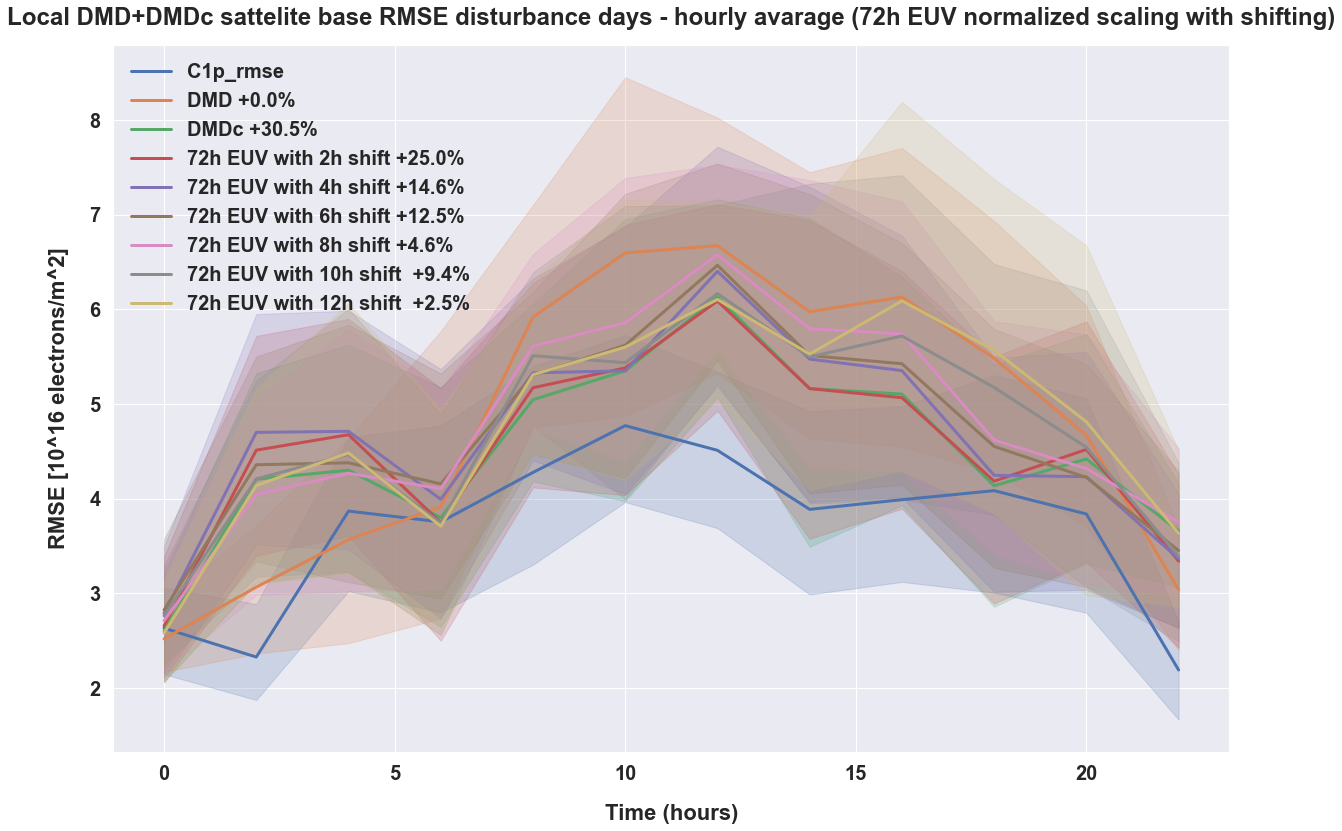

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22], dtype=int64)

In [146]:

# days_type = 'quite'
# days_type = 'disturbance'
# days = 2 #1,2,3
rmse_df = pd.read_csv(os.path.join('DMD results','dataframe_result_{}_{}h_islocal_{}.csv'.format(days_type,days*24,not sat_paths_file is None)))

mean_dict = {t:[] for t in rmse_df.columns[1:]}
improve_presentage = {}
# print(mean_dict)
for t in rmse_df.time.unique():
    tdf = rmse_df.loc[rmse_df['time'] == t].describe()
    # print(tdf)
    for c in mean_dict.keys():
        mean_dict[c].append(tdf[c]['mean'])

for c in mean_dict.keys():
    mean_dict[c] = np.array(mean_dict[c])
    # print(tdf.describe()['pred_tec_shift_4_rmse']['mean'])

base_area = np.trapz(mean_dict['no_control_rmse']-mean_dict['ref_rmse'])
for c,arr in mean_dict.items():
    ref_mean = mean_dict['no_control_rmse']
    area = np.trapz(ref_mean - arr)
    improve_presentage[c] = (area / base_area) *100

# print(improve_presentage)

fig, ax = plt.subplots(figsize=(20,13))
linewidth = 3
sns.set_theme()
sns.lineplot(data=rmse_df, x="time", y="ref_rmse",label="C1p_rmse",linewidth = linewidth)
sns.lineplot(data=rmse_df, x="time", y="no_control_rmse",label="DMD +{:.1f}%".format(improve_presentage['no_control_rmse']),linewidth = linewidth)


sns.lineplot(data=rmse_df, x="time", y="with_control_rmse",label="DMDc +{:.1f}%".format(improve_presentage['with_control_rmse']),linewidth = linewidth)#, hue="event")
sns.lineplot(data=rmse_df, x="time", y="pred_tec_shift_2_rmse", label="{}h EUV with 2h shift +{:.1f}%".format(  days*24,improve_presentage['pred_tec_shift_2_rmse']),linewidth = linewidth)
sns.lineplot(data=rmse_df, x="time", y="pred_tec_shift_4_rmse", label="{}h EUV with 4h shift +{:.1f}%".format(  days*24,improve_presentage['pred_tec_shift_4_rmse']),linewidth = linewidth)
sns.lineplot(data=rmse_df, x="time", y="pred_tec_shift_6_rmse", label="{}h EUV with 6h shift +{:.1f}%".format(  days*24,improve_presentage['pred_tec_shift_6_rmse']),linewidth = linewidth)
sns.lineplot(data=rmse_df, x="time", y="pred_tec_shift_8_rmse", label="{}h EUV with 8h shift +{:.1f}%".format(  days*24,improve_presentage['pred_tec_shift_8_rmse']),linewidth = linewidth)
sns.lineplot(data=rmse_df, x="time", y="pred_tec_shift_10_rmse",label="{}h EUV with 10h shift  +{:.1f}%".format(days*24,improve_presentage['pred_tec_shift_10_rmse']),linewidth = linewidth)
sns.lineplot(data=rmse_df, x="time", y="pred_tec_shift_12_rmse",label="{}h EUV with 12h shift  +{:.1f}%".format(days*24,improve_presentage['pred_tec_shift_12_rmse']),linewidth = linewidth)

ax.set_xlabel("Time (hours)",fontsize = 22,fontweight='bold',labelpad=20)
ax.set_ylabel("RMSE [10^16 electrons/m^2]",fontsize = 22,fontweight='bold',labelpad=20)

if sat_paths_file:
    ax.set_title("Local DMD+DMDc sattelite base RMSE {} days - hourly avarage ({}h EUV normalized scaling with shifting)".format(days_type,days*24),fontsize = 24,fontweight='bold',pad=20)
else:
    ax.set_title("Global DMD+DMDc RMSE {} days - hourly avarage ({}h EUV normalized scaling with shifting)".format(days_type,days*24),fontsize = 24,fontweight='bold',pad=20)
# ax.set_title("Global to Local DMD+DMDc disturbance days - hourly avarage (normalized scaling)[lat: 12 - 47 ,lon: 14 - 57]",fontsize = 20,fontweight='bold')
# ax.set_title("Global DMD+DMDc disturbance days - hourly avarage (normalized scaling)[lat: 12 - 47 ,lon: 14 - 57]",fontsize = 20,fontweight='bold')
# ax.set_title("Global to Local DMD+DMDc quiet days - hourly avarage (normalized scaling)[lat: 12 - 47 ,lon: 14 - 57]",fontsize = 20,fontweight='bold')
# ax.set_title("DMD+DMDc quite days - hourly avarage",fontsize = 20,fontweight='bold')

# ax.tick_params(labelsize =12)


plt.xticks(fontsize=20,fontweight='bold')
plt.yticks(fontsize=20,fontweight='bold')

plt.legend(prop={'weight':'bold','size':20})


# plt.legend(prop={'size': 12})
plt.show()
rmse_df.time.unique()

In [147]:
return

SyntaxError: 'return' outside function (<ipython-input-147-9b32c1431b19>, line 1)

In [ ]:
import cartopy.crs as ccrs

sat_paths_file = glob.glob(os.path.join('mafat','data_map_case_study_25_04_2014_00_00_24_00_all_IPP.mat'))[0]
sat_paths = scipy.io.loadmat(sat_paths_file)
        
keys_list = list(sat_paths.keys())[3:]
# key_pairs = np.concatenate((keys_list[::2],keys_list[1::2]))
key_pairs = list(zip(keys_list[::2],keys_list[1::2]))

lats_key = keys_list[::2]
lons_key = keys_list[1::2]

sat_paths['ipp_station_no_all_sat_lat_0_2'].shape
np.linspace(87.5,-87.5,71)[30],np.linspace(-180,180,73)[38]#,latlon2index((40.5786878,16.24735467))

(12.5, 10.0)

### BUILD IONEX FILES

In [15]:
for day,val_dict in comparison_dict.items():
    index = val_dict['date_index'] // 12
    # dmdc = np.array(val_dict['full_dmdc'],dtype=np.int)
    dmd = np.array(val_dict['full_dmd'],dtype=np.int)
    # dmdc_shift2 = np.array(val_dict['full_pred_tec_shift_2'],dtype=np.int)
    c1p_file_path = c1p_file_names[index]
    # print(np.min(dmd.reshape(13,-1)),dmd.shape)
    # dmd_ionex(c1p_file_path,dmdc_shift2,_replace_with='dmdc_euv{}h_shift2'.format(days*24),debug=False)
    # dmd_ionex(c1p_file_path,dmdc,_replace_with='dmdc_euv{}h'.format(days*24),debug=False)
    dmd_ionex(c1p_file_path,dmd,_replace_with='dmd_rms{}h'.format(days*24),debug=False)

    print(day,dmd.shape)

/Users/vladlanda/opt/anaconda3/envs/phd37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


25/02/2014 (1, 13, 71, 73)
24/10/2014 (1, 13, 71, 73)
10/06/2014 (1, 13, 71, 73)
27/10/2014 (1, 13, 71, 73)
26/10/2014 (1, 13, 71, 73)
20/12/2014 (1, 13, 71, 73)
07/11/2014 (1, 13, 71, 73)
22/10/2014 (1, 13, 71, 73)
10/09/2014 (1, 13, 71, 73)
25/04/2014 (1, 13, 71, 73)


No handles with labels found to put in legend.


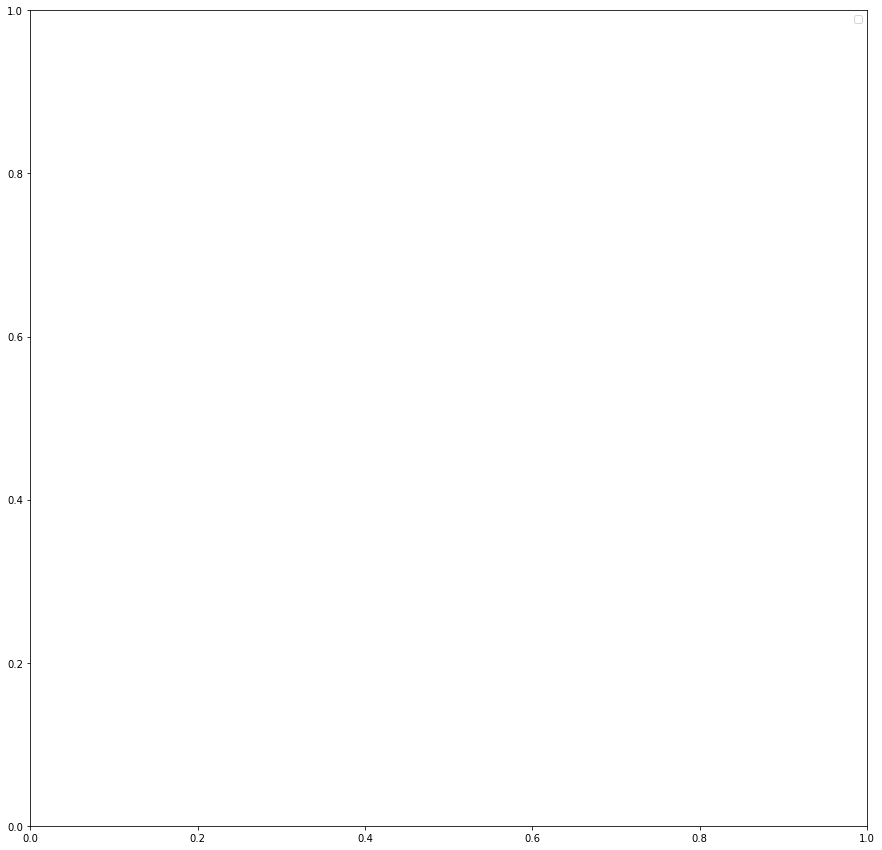

In [ ]:
plt.figure(figsize=(15,15))
# true_tec = comparison_dict[da.strftime(datetime_str)]['true_tec']
# true_tec = comparison_dict[da.strftime(datetime_str)]['pred_tec']
# ref_rmse = comparison_dict[da.strftime(datetime_str)]['ref_rmse']
# pred_rmse = comparison_dict[da.strftime(datetime_str)]['pred_rmse']
# no_control_rmse = comparison_dict[da.strftime(datetime_str)]['no_control_rmse']
# # index = 1
# # for row in range(true_tec.shape[0]):
# #     # for col in range(pred_maps.shape[0]):
# #     plt.subplot(true_tec.shape[0],1,index)
# #     plt.imshow(true_tec[row])
# #     # plt.imshow(true_tec[row].reshape(71,73))

# #     index+=1

# # plt.show()

# plt.plot(ref_rmse,label='ref')
# plt.plot(pred_rmse,label='pred')
# plt.plot(no_control_rmse,label='no control')
plt.legend()
plt.show()
# ref_rmse.shape

In [ ]:
d,s,h,w = igs_cp.shape

A = igs_cp.reshape(d*s,h*w).T
B = daily_irr.reshape(d*s,-1).T
C = c1p_cp.reshape(d*s,h*w).T

# pred_maps = DMDc_prediction(A,B,370*12,100*12,5)
# pred_maps.shape


# index = 1
# for row in range(pred_maps.shape[1]):
#     for col in range(pred_maps.shape[0]):
#         plt.subplot(pred_maps.shape[1],pred_maps.shape[0],index)
#         plt.imshow(pred_maps[col,row].reshape(h,w))

#         index+=1

# plt.show()
A.shape,np.max(A),np.min(A)

((5183, 8712), 147.1, 0.0)

In [ ]:
# (Phi,Ur_prime,A_tilda,B_tilda) = DMDc(X,X_prime,Y=None)
# (Phi,Ur_prime,A_tilda,B_tilda) = DMDc(X,X_prime,Y)

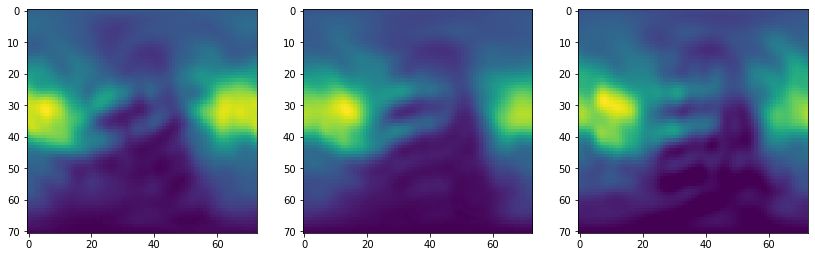

(2.6418250930931486, 5.0144473802423395)

In [ ]:
# a = A[:,_to]
# y = B[:,_to]
# c = C[:,_to]

# a_tilda = Ur_prime.T @ a
# p = Ur_prime @ (A_tilda @ a_tilda)
# if not B_tilda is np.nan:
#     p = Ur_prime @ (A_tilda @ a_tilda + B_tilda @ y)


# plt.subplot(1,3,1)
# plt.imshow(p.reshape(h,w))


# plt.subplot(1,3,2)
# plt.imshow(a.reshape(h,w))


# plt.subplot(1,3,3)
# plt.imshow(c.reshape(h,w))

# plt.show()

# maps_rmse(c.reshape(h,w),a.reshape(h,w)),maps_rmse(p.reshape(h,w),a.reshape(h,w))

In [ ]:
yyy = np.array([1,2,3,4,5,6,7,8,9])
yyy[1:5],yyy[5]

(array([2, 3, 4, 5]), 6)

##### EXAMPLE

[[1.5 0. ]
 [0.  0.1]] (2, 2) 
 [[4]
 [7]] (2, 1) 
 [[-1]] (1, 1) 
 [[1]
 [0]] (2, 1)
(2, 201) (1, 200)


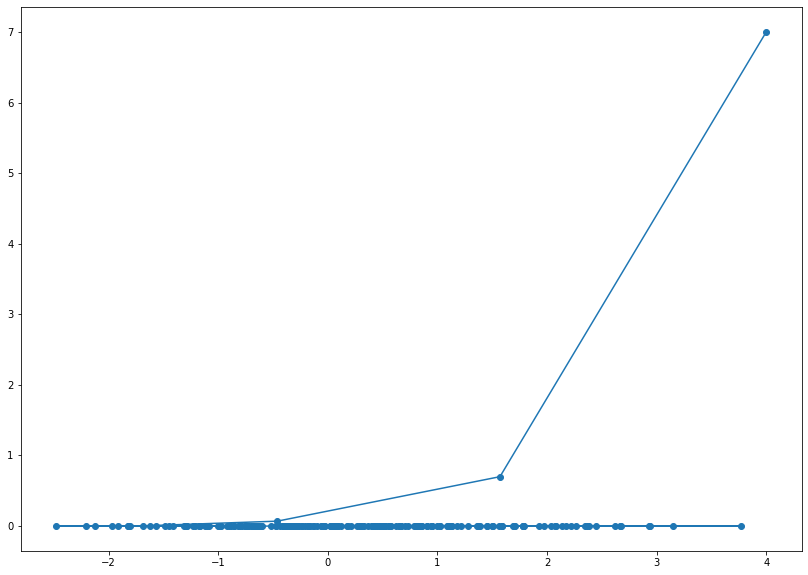

In [ ]:
#Simulation
A = np.array([[1.5,0],[0,0.1]])
x0 = np.array([[4,7]]).T
K = np.array([[-1]]).T
B = np.array([[1,0]]).T
m = 200
dataX = [x0]
dataU = [0] * m

print(A,A.shape,'\n',x0,x0.shape,'\n',K,K.shape,'\n',B,B.shape)

for i in range(m):
    sigma_k = np.random.normal(0,1)
    x_k1 = A @ dataX[i] + B * (K * dataX[i][0] + sigma_k)
    u_k1 = K * dataX[i][0] + sigma_k

    dataX.append(x_k1)
    dataU[i] = u_k1

dataX = np.array(dataX).T.reshape(2,-1)
dataU = np.array(dataU).T.reshape(1,-1)

print(dataX.shape,dataU.shape)


fig = plt.figure()
# ax = plt.axes(projection='3d')
plt.plot(dataX[0,:],dataX[1,:])
plt.scatter(dataX[0,:],dataX[1,:])
# plt.hist(np.random.normal(0,0.0,1000),bins=32)
plt.show()

# dataX,dataU

In [ ]:
# X = np.array([[4,2,1,0.5],[7,0.7,0.07,0.007]])
# Xprime = np
# .array([[2,1,0.5,0.25],[0.7,0.07,0.007,0.0007]])
# Y = np.array([-4,-2,-1,-0.5]).reshape(1,-1)

X = dataX[:,:-1]
Xprime = dataX[:,1:]
Y = dataU

# print(X,Xprime,Y)

# print(X.shape,Y.shape,Xprime.shape)
(Phi,A_tilda,B_tilda) = DMDc(X,Xprime,Y)
A_tilda,B_tilda

(2, 3) (3, 3) (200, 3)


(array([[1.49998081, 0.00518268],
        [0.00518268, 0.10001919]]),
 array([[-0.99999315],
        [-0.00370194]]))

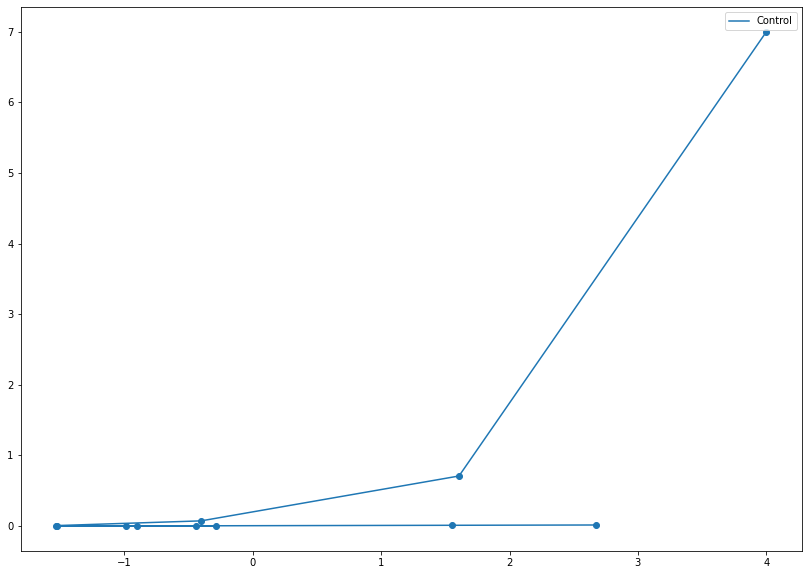

In [ ]:
dataX = [x0]
dataX2 = [x0]
# dataU = [0] * m
m=10
for i in range(m):
    # print(dataU[0][i],B_tilda * dataU[0][i])
    x_k1 = A_tilda @ dataX[i] - B_tilda * dataU[0][i]#dataX[i][0] #+ np.random.normal(0,0.02)
    
    # u_k1 = K * dataX[i][0]

    dataX.append(x_k1)
    dataX2.append(A_tilda @ dataX2[i])
    # dataU[i] = u_k1

dataX = np.array(dataX).T.reshape(2,-1)
dataX2 = np.array(dataX2).T.reshape(2,-1)
# dataU = np.array(dataU).T.reshape(1,-1)

# print(dataX.shape,dataU.shape)

fig = plt.figure()
# ax = plt.axes(projection='3d')
plt.plot(dataX[0,:],dataX[1,:],label='Control')
plt.scatter(dataX[0,:],dataX[1,:])

# plt.plot(dataX2[0,:],dataX2[1,:],label='No control')
# plt.scatter(dataX2[0,:],dataX2[1,:])
plt.legend()
plt.show()

In [ ]:
from scipy import interpolate
a = np.arange(12.).reshape((4, 3))
a

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.],
       [ 9., 10., 11.]])

In [ ]:
f = interpolate.interp1d(range(4), a,axis=0)
b = f(np.arange(0, 3, 0.1))

In [ ]:

b.shape,b

((30, 3),
 array([[ 0. ,  1. ,  2. ],
        [ 0.3,  1.3,  2.3],
        [ 0.6,  1.6,  2.6],
        [ 0.9,  1.9,  2.9],
        [ 1.2,  2.2,  3.2],
        [ 1.5,  2.5,  3.5],
        [ 1.8,  2.8,  3.8],
        [ 2.1,  3.1,  4.1],
        [ 2.4,  3.4,  4.4],
        [ 2.7,  3.7,  4.7],
        [ 3. ,  4. ,  5. ],
        [ 3.3,  4.3,  5.3],
        [ 3.6,  4.6,  5.6],
        [ 3.9,  4.9,  5.9],
        [ 4.2,  5.2,  6.2],
        [ 4.5,  5.5,  6.5],
        [ 4.8,  5.8,  6.8],
        [ 5.1,  6.1,  7.1],
        [ 5.4,  6.4,  7.4],
        [ 5.7,  6.7,  7.7],
        [ 6. ,  7. ,  8. ],
        [ 6.3,  7.3,  8.3],
        [ 6.6,  7.6,  8.6],
        [ 6.9,  7.9,  8.9],
        [ 7.2,  8.2,  9.2],
        [ 7.5,  8.5,  9.5],
        [ 7.8,  8.8,  9.8],
        [ 8.1,  9.1, 10.1],
        [ 8.4,  9.4, 10.4],
        [ 8.7,  9.7, 10.7]]))

In [ ]:
a = np.array([[1, 2],[5,6]])
# b = np.pad(a, ((0,0),(10,0)))[:,:-10]
# b[:,:-5]
# b.insert(2),

a.shape
b = np.pad(a,(10,0))
mask = b != 0 
mask,np.sum(mask)

(array([[False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
 

In [ ]:
a = np.zeros((3,4,7))
a[:,0,0] = 5
a[:,3,6] = 6
a[1,3,6] = 69
# a = a *0.1

np.mean(np.square(a))


((5**2+6**2)/(2))**0.5,np.sqrt(np.sum(np.square(a),axis=(1,2)) / np.sum(a != 0,axis=(1,2)))

NameError: name 'np' is not defined

In [ ]:
import datetime

Ds = [25,24,10,27,26,20,7,22,10,25]
Ms = [2,10,6,10,10,12,11,10,9,4]
#quit time
Ds = [23,25,15,26,9,29,23,22,20,11]
Ms = [8,1,2,3,4,5,6,7,9,10]

Ys = [2014]*len(Ds)
tt = []
for d,m,y in zip(Ds,Ms,Ys):

    t = datetime.datetime(y,m,d).strftime('%d/%m/%Y')
    print(t)

23/08/2014
25/01/2014
15/02/2014
26/03/2014
09/04/2014
29/05/2014
23/06/2014
22/07/2014
20/09/2014
11/10/2014
